In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "IGH_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-Myositis-IGH_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20210503-Myositis-datasheet.csv"
run = "runMyositis"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: runMyositis-similarity-IGH_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,E2134-17-B2_S222,ACGTACGT,CATTFISGTTGYWGQGTLVT,2680,394,IGHV3-7,"IGHJ4,IGHJ5",20,0.007463,46.698031,31.672026
1,E2134-17-B2_S222,ACGTACGT,CAKREGYRQNWFAPWGQGTLVT,1196,230,IGHV3-23,"IGHJ5,IGHJ4",2365,1.977425,20.839868,18.488746
2,E2134-17-B2_S222,ACGTACGT,CARDHTETLFYYYYMGVWGKGTTVT,232,52,IGHV3-7,IGHJ6,2,0.008621,4.042516,4.180064
3,E2134-17-B2_S222,ACGTACGT,CARAAAGLDYWGQGNLVT,139,34,IGHV3-72,IGHJ4,0,0.000000,2.422025,2.733119
4,E2134-17-B2_S222,ACGTACGT,CASDPPNSNYAFHNWGQGTLVT,137,28,IGHV3-30,IGHJ4,1,0.007299,2.387175,2.250804


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
730208,T19-00509-B_S108,CTHSLGHGDYIAWGQGTLVT,2812,805,2799,0.995377,13.159249,8.963367
730009,T19-00509-B_S108,CARVRGDCFTTSCHGPFDIWGQGTKVT,1668,583,28,0.016787,7.805700,6.491482
729926,T19-00509-B_S108,CARSPDMWNGRHTEDDHWGQGTLVT,1093,396,14,0.012809,5.114886,4.409309
729399,T19-00509-B_S108,CAKDATSGSPNYFDPWGQGTLVT,1081,330,5,0.004625,5.058730,3.674424
729696,T19-00509-B_S108,CARESYSTPPFDPWGQGTLVT,1059,354,5,0.004721,4.955777,3.941655


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,Sample_Project,Species,Chain,Patient,SampleInfo,UMI
0,N711_S502,MYO101base-B,NaN,NaN,NaN,NaN,NaN,NaN,RUN36,S9,Myositis,human,BCRh,MYO101,Week 0,yes
1,N712_S502,MYO102base-B,NaN,NaN,NaN,NaN,NaN,NaN,RUN36,S10,Myositis,human,BCRh,MYO102,Week 0,yes
2,N714_S502,MYO103base-B,NaN,NaN,NaN,NaN,NaN,NaN,RUN36,S11,Myositis,human,BCRh,MYO103,Week 0,yes
3,N715_S502,MYO104base-B,NaN,NaN,NaN,NaN,NaN,NaN,RUN36,S12,Myositis,human,BCRh,MYO104,Week 0,yes
4,N716_S502,MYO105base-B,NaN,NaN,NaN,NaN,NaN,NaN,RUN36,S13,Myositis,human,BCRh,MYO105,Week 0,yes


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,MYO101base-B_S9,MYO101
1,MYO102base-B_S10,MYO102
2,MYO103base-B_S11,MYO103
3,MYO104base-B_S12,MYO104
4,MYO105base-B_S13,MYO105


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,T19-00509-B_S108,CTHSLGHGDYIAWGQGTLVT,2812,805,2799,0.995377,13.159249,8.963367,MYO115
1,T19-00509-B_S108,CARVRGDCFTTSCHGPFDIWGQGTKVT,1668,583,28,0.016787,7.805700,6.491482,MYO115
2,T19-00509-B_S108,CARSPDMWNGRHTEDDHWGQGTLVT,1093,396,14,0.012809,5.114886,4.409309,MYO115
3,T19-00509-B_S108,CAKDATSGSPNYFDPWGQGTLVT,1081,330,5,0.004625,5.058730,3.674424,MYO115
4,T19-00509-B_S108,CARESYSTPPFDPWGQGTLVT,1059,354,5,0.004721,4.955777,3.941655,MYO115


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                        MYO101                                         \
Sample                MYO101base-B_S9 MYO101base2-B2H_S63 MYO101base2-B2_S59   
cdr3pep                                                                        
AAAGYWFDPWGQGTLVT                 0.0                 0.0                0.0   
AAVTDSYYGMDVWGQGTTVT              0.0                 0.0                0.0   
AHAVDYWGQGTLVT                    0.0                 0.0                0.0   
ALLDSSYYYGMDVWGQGTTVT             0.0                 0.0                0.0   
ALLLSPSNGMDVWGQGTTVT              0.0                 0.0                0.0   

Patient                                                                   \
Sample                MYO101base2-B_S203 MYO101end-B_S45 T17-04319-B_S78   
cdr3pep                                                                    
AAAGYWFDPWGQGTLVT                    0.0             0.0             0.0   
AAVTDSYYGMDVWGQGTTVT                 0.0             0.0             0.0   
AHAVDYWGQGTLVT                       0.0             0.0             0.0   
ALLDSSYYYGMDVWGQGTTVT                0.0             0.0             0.0   
ALLLSPSNGMDVWGQGTTVT                 0.0             0.0             0.0   

Patient                         MYO102                                     \
Sample                MYO102base-B_S10 MYO102base2-B_S204 MYO102end-B_S46   
cdr3pep                                                                     
AAAGYWFDPWGQGTLVT                  0.0                0.0             0.0   
AAVTDSYYGMDVWGQGTTVT               0.0                0.0             0.0   
AHAVDYWGQGTLVT                     0.0                0.0             0.0   
ALLDSSYYYGMDVWGQGTTVT              0.0                0.0             0.0   
ALLLSPSNGMDVWGQGTTVT               0.0                0.0             0.0   

Patient                                         ...                  MYO202  \
Sample                MYO102week52-B_S175       ...        MYO202base-B_S42   
cdr3pep                                         ...                           
AAAGYWFDPWGQGTLVT                     0.0       ...                     0.0   
AAVTDSYYGMDVWGQGTTVT                  0.0       ...                     0.0   
AHAVDYWGQGTLVT                        0.0       ...                     0.0   
ALLDSSYYYGMDVWGQGTTVT                 0.0       ...                     0.0   
ALLLSPSNGMDVWGQGTTVT                  0.0       ...                     0.0   

Patient                        MYO203                                   \
Sample                E2208-34-B2_S72 E2208-34-B_S107 MYO203base-B_S43   
cdr3pep                                                                  
AAAGYWFDPWGQGTLVT                 0.0             0.0              0.0   
AAVTDSYYGMDVWGQGTTVT              0.0             0.0              0.0   
AHAVDYWGQGTLVT                    0.0             0.0              0.0   
ALLDSSYYYGMDVWGQGTTVT             0.0             0.0              0.0   
ALLLSPSNGMDVWGQGTTVT              0.0             0.0              0.0   

Patient                                                               MYO301  \
Sample                MYO203end2-B_S206 MYO203week52-B_S202 MYO301base-B_S44   
cdr3pep                                                                        
AAAGYWFDPWGQGTLVT                   0.0                 0.0              0.0   
AAVTDSYYGMDVWGQGTTVT                0.0                 0.0              0.0   
AHAVDYWGQGTLVT                      0.0                 0.0              0.0   
ALLDSSYYYGMDVWGQGTTVT               0.0                 0.0              0.0   
ALLLSPSNGMDVWGQGTTVT                0.0                 0.0              0.0   

Patient                                                                   
Sample                MYO301end-B_S77 Pt301UMCG-B2_S223 Pt301UMCG-B_S121  
cdr3pep                                                                   
AAAGYWFDPWGQGTLVT                 0.0    

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                              MYO101                      \
Sample                      MYO101base-B_S9 MYO101base2-B2H_S63   
Patient Sample                                                    
MYO101  MYO101base-B_S9            1.000000            0.092356   
        MYO101base2-B2H_S63        0.092356            1.000000   
        MYO101base2-B2_S59         0.093244            0.320379   
        MYO101base2-B_S203         0.136048            0.296802   
        MYO101end-B_S45            0.008601            0.032197   

Patient                                                            \
Sample                      MYO101base2-B2_S59 MYO101base2-B_S203   
Patient Sample                                                      
MYO101  MYO101base-B_S9               0.093244           0.136048   
        MYO101base2-B2H_S63           0.320379           0.296802   
        MYO101base2-B2_S59            1.000000           0.334060   
        MYO101base2-B_S203            0.334060           1.000000   
        MYO101end-B_S45               0.027202           0.021697   

Patient                                                               MYO102  \
Sample                      MYO101end-B_S45 T17-04319-B_S78 MYO102base-B_S10   
Patient Sample                                                                 
MYO101  MYO101base-B_S9            0.008601        0.013242              0.0   
        MYO101base2-B2H_S63        0.032197        0.032268              0.0   
        MYO101base2-B2_S59         0.027202        0.051822              0.0   
        MYO101base2-B_S203         0.021697        0.030951              0.0   
        MYO101end-B_S45            1.000000        0.024979              0.0   

Patient                                                         \
Sample                      MYO102base2-B_S204 MYO102end-B_S46   
Patient Sample                                                   
MYO101  MYO101base-B_S9                    0.0        0.000000   
        MYO101base2-B2H_S63                0.0        0.000000   
        MYO101base2-B2_S59                 0.0        0.000000   
        MYO101base2-B_S203                 0.0        0.000000   
        MYO101end-B_S45                    0.0        0.000075   

Patient                                               ...         \
Sample                      MYO102week52-B_S175       ...          
Patient Sample                                        ...          
MYO101  MYO101base-B_S9                     0.0       ...          
        MYO101base2-B2H_S63                 0.0       ...          
        MYO101base2-B2_S59                  0.0       ...          
        MYO101base2-B_S203                  0.0       ...          
        MYO101end-B_S45                     0.0       ...          

Patient                               MYO202          MYO203                  \
Sample                      MYO202base-B_S42 E2208-34-B2_S72 E2208-34-B_S107   
Patient Sample                                                                 
MYO101  MYO101base-B_S9             0.000000        0.000000        0.000000   
        MYO101base2-B2H_S63         0.000000        0.000000        0.000068   
        MYO101base2-B2_S59          0.000042        0.000045        0.000068   
        MYO101base2-B_S203          0.000000        0.000000        0.000000   
        MYO101end-B_S45             0.000193        0.000029        0.000000   

Patient                                                         \
Sample                      MYO203base-B_S43 MYO203end2-B_S206   
Patient Sample                                                   
MYO101  MYO101base-B_S9             0.000000          0.000000   
        MYO101base2-B2H_S63         0.000000          0.000000   
        MYO101base2-B2_S59          0.000112          0.000000   
        MYO101base2-B_S203          0.000000          0.000046   
        MYO101end-B_S45             0.000025          0.000000   

Patient                  

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote runMyositis-similarity-IGH_HUMAN.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 1.565055442087626e-05
max value: 1.0
Wrote runMyositis-similarity-IGH_HUMAN.pdf to disk


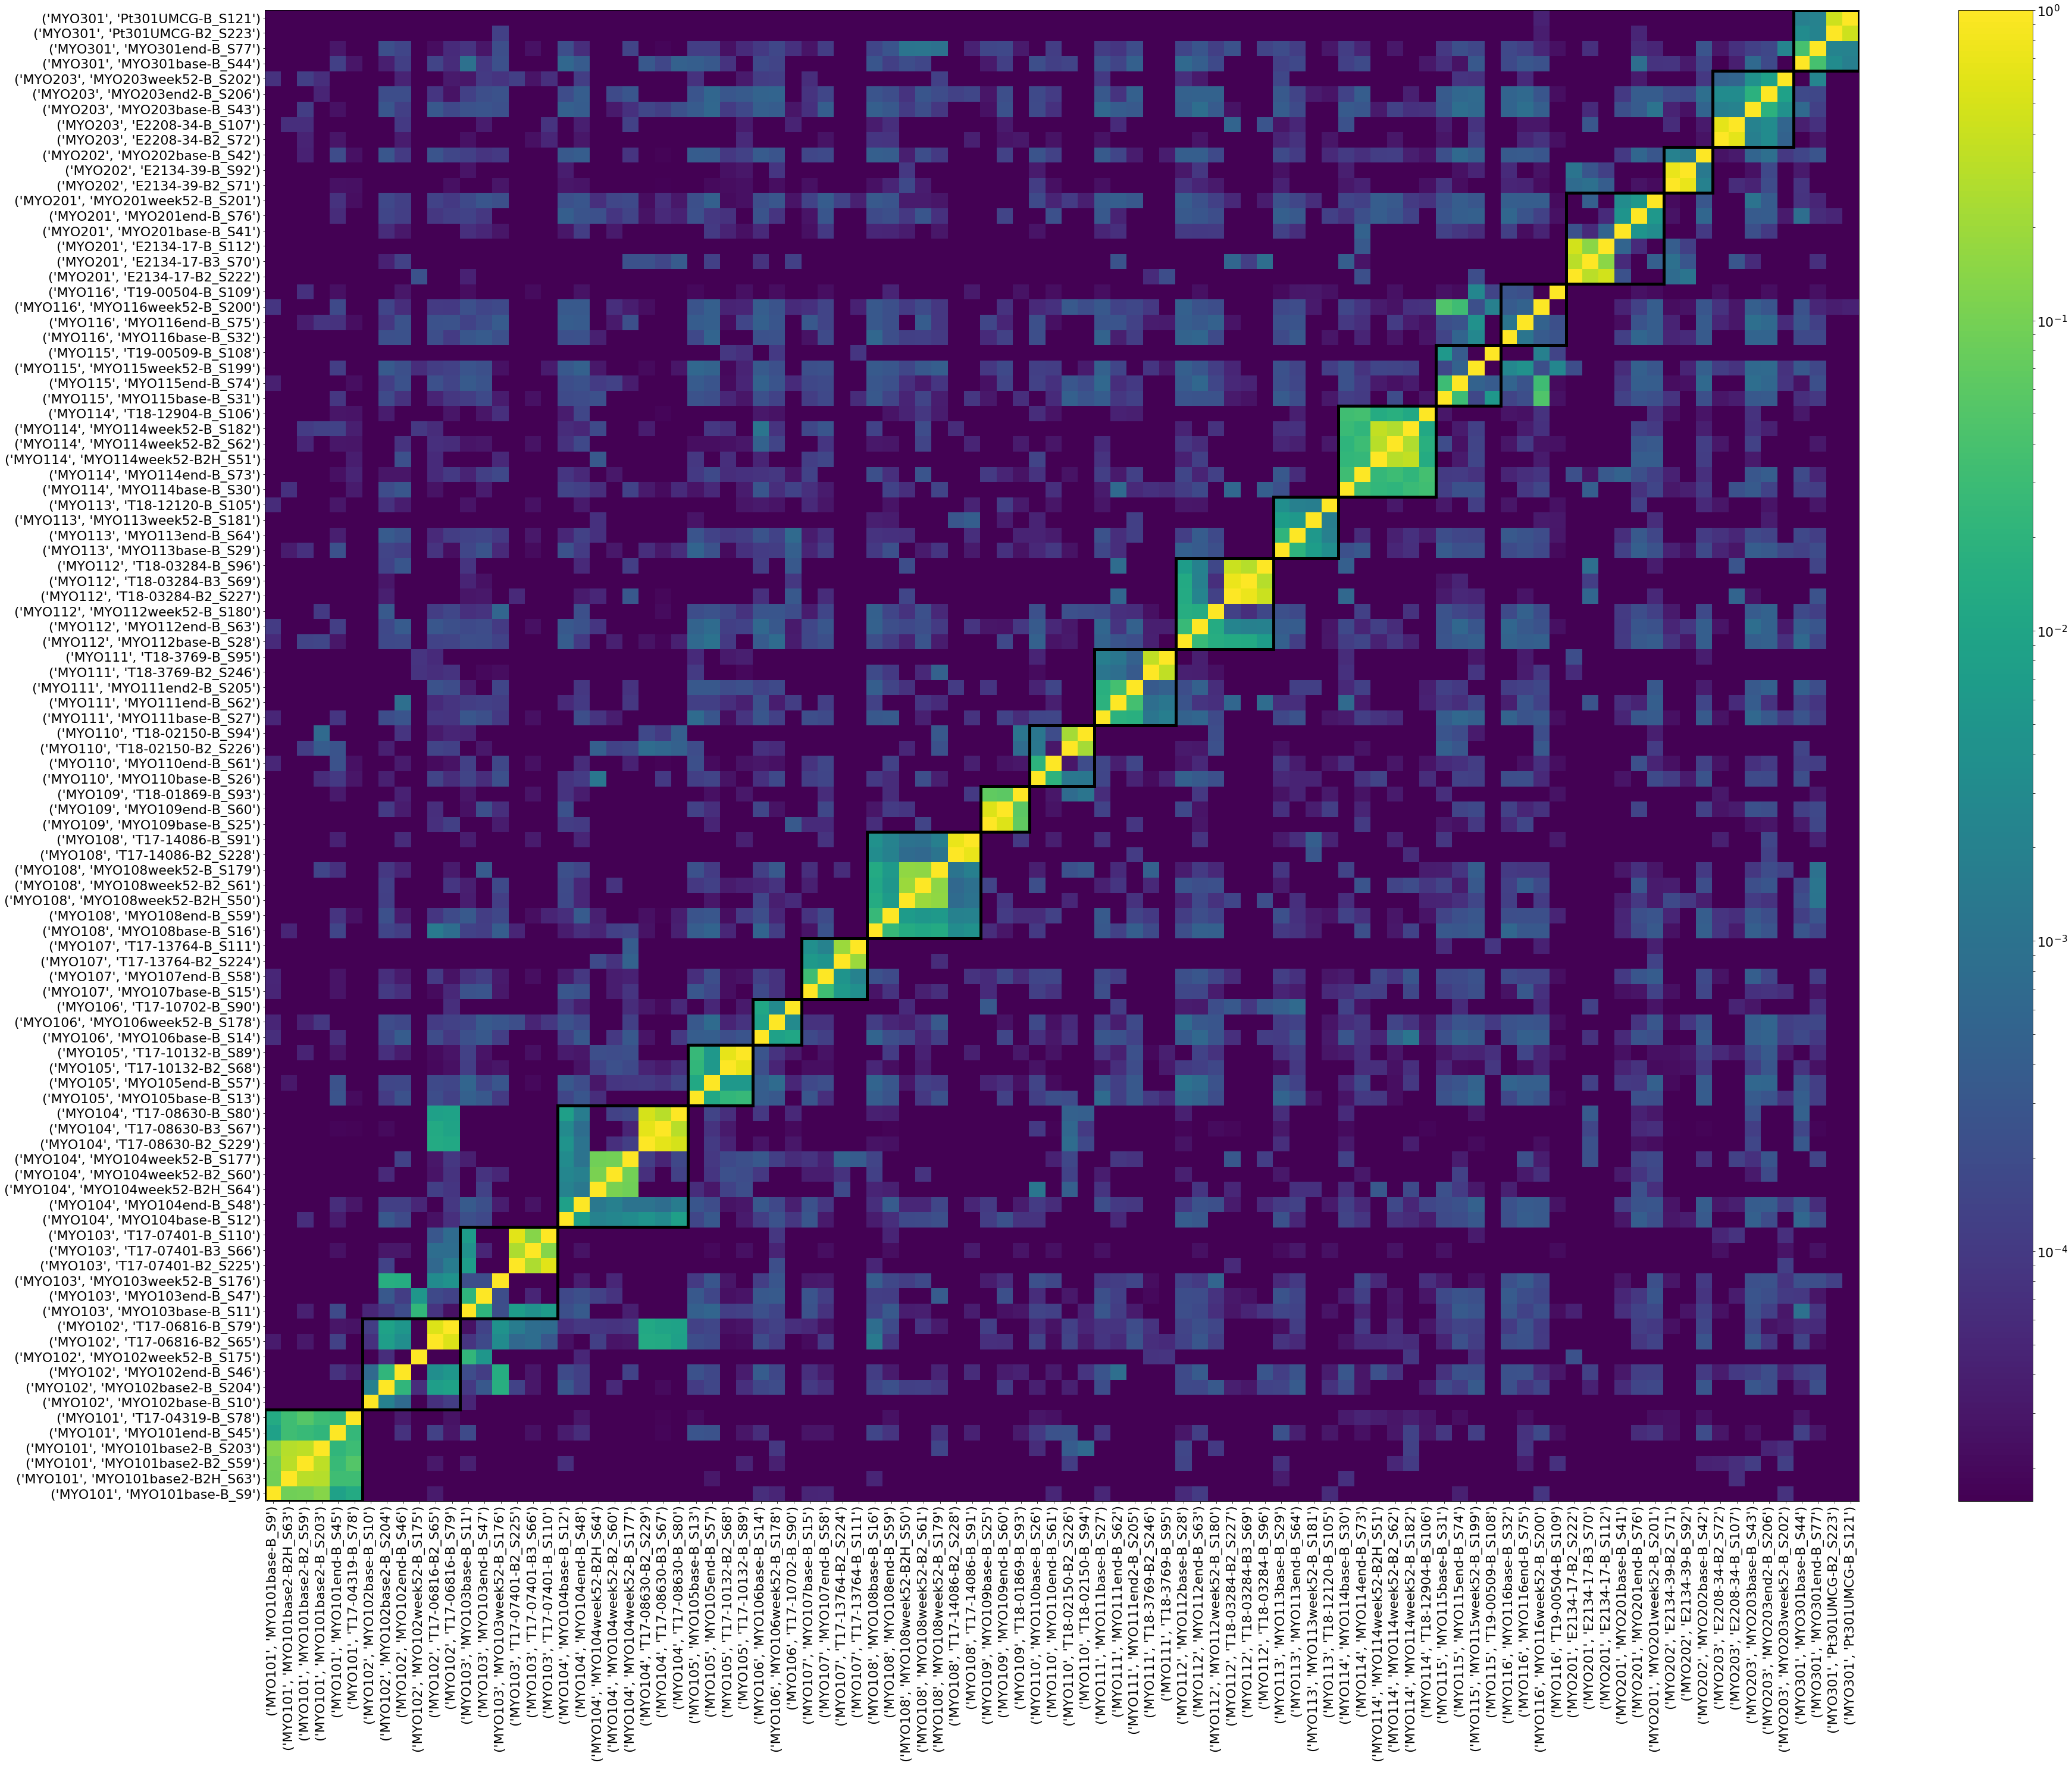

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.06758806632536421 0.15357070894868957
mean diff patient 0.00012120710522929006 0.0010554370904343124
threshold 0.00434295546696654


{'whiskers': [<matplotlib.lines.Line2D at 0x7f4915522e80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f491552b780>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4915522d30>,
 'medians': [<matplotlib.lines.Line2D at 0x7f491552bfd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f4915533438>,
 'means': []}

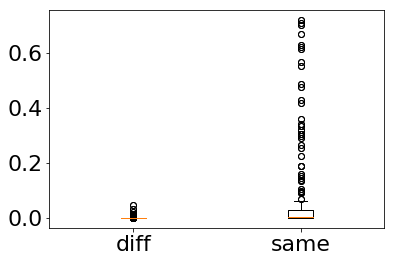

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

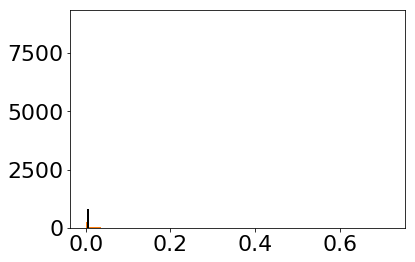

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('MYO102', 'MYO102base2-B_S204') ('MYO103', 'MYO103week52-B_S176') 0.015807791624564915
('MYO102', 'MYO102end-B_S46') ('MYO103', 'MYO103week52-B_S176') 0.014666080640310941
('MYO102', 'MYO102week52-B_S175') ('MYO103', 'MYO103base-B_S11') 0.022310323383084585
('MYO102', 'MYO102week52-B_S175') ('MYO103', 'MYO103end-B_S47') 0.005198810441678581
('MYO102', 'T17-06816-B2_S65') ('MYO104', 'T17-08630-B2_S229') 0.013037809647979182
('MYO102', 'T17-06816-B2_S65') ('MYO104', 'T17-08630-B3_S67') 0.0124085734764815
('MYO102', 'T17-06816-B2_S65') ('MYO104', 'T17-08630-B_S80') 0.008048289738430636
('MYO102', 'T17-06816-B_S79') ('MYO104', 'T17-08630-B2_S229') 0.011687174998712857
('MYO102', 'T17-06816-B_S79') ('MYO104', 'T17-08630-B3_S67') 0.00971127898266233
('MYO102', 'T17-06816-B_S79') ('MYO104', 'T17-08630-B_S80') 0.009006517874777797
('MYO103', 'MYO103base-B_S11') ('MYO102', 'MYO102week52-B_S175') 0.022310323383084585
('MYO103', 'MYO103end-B_S47') ('MYO102', 'MYO102week52-B_S175') 0.005198810441

In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 1.565055442087626e-05
max value: 1.0
Wrote runMyositis-similarity-IGH_HUMAN-highlighted.pdf to disk


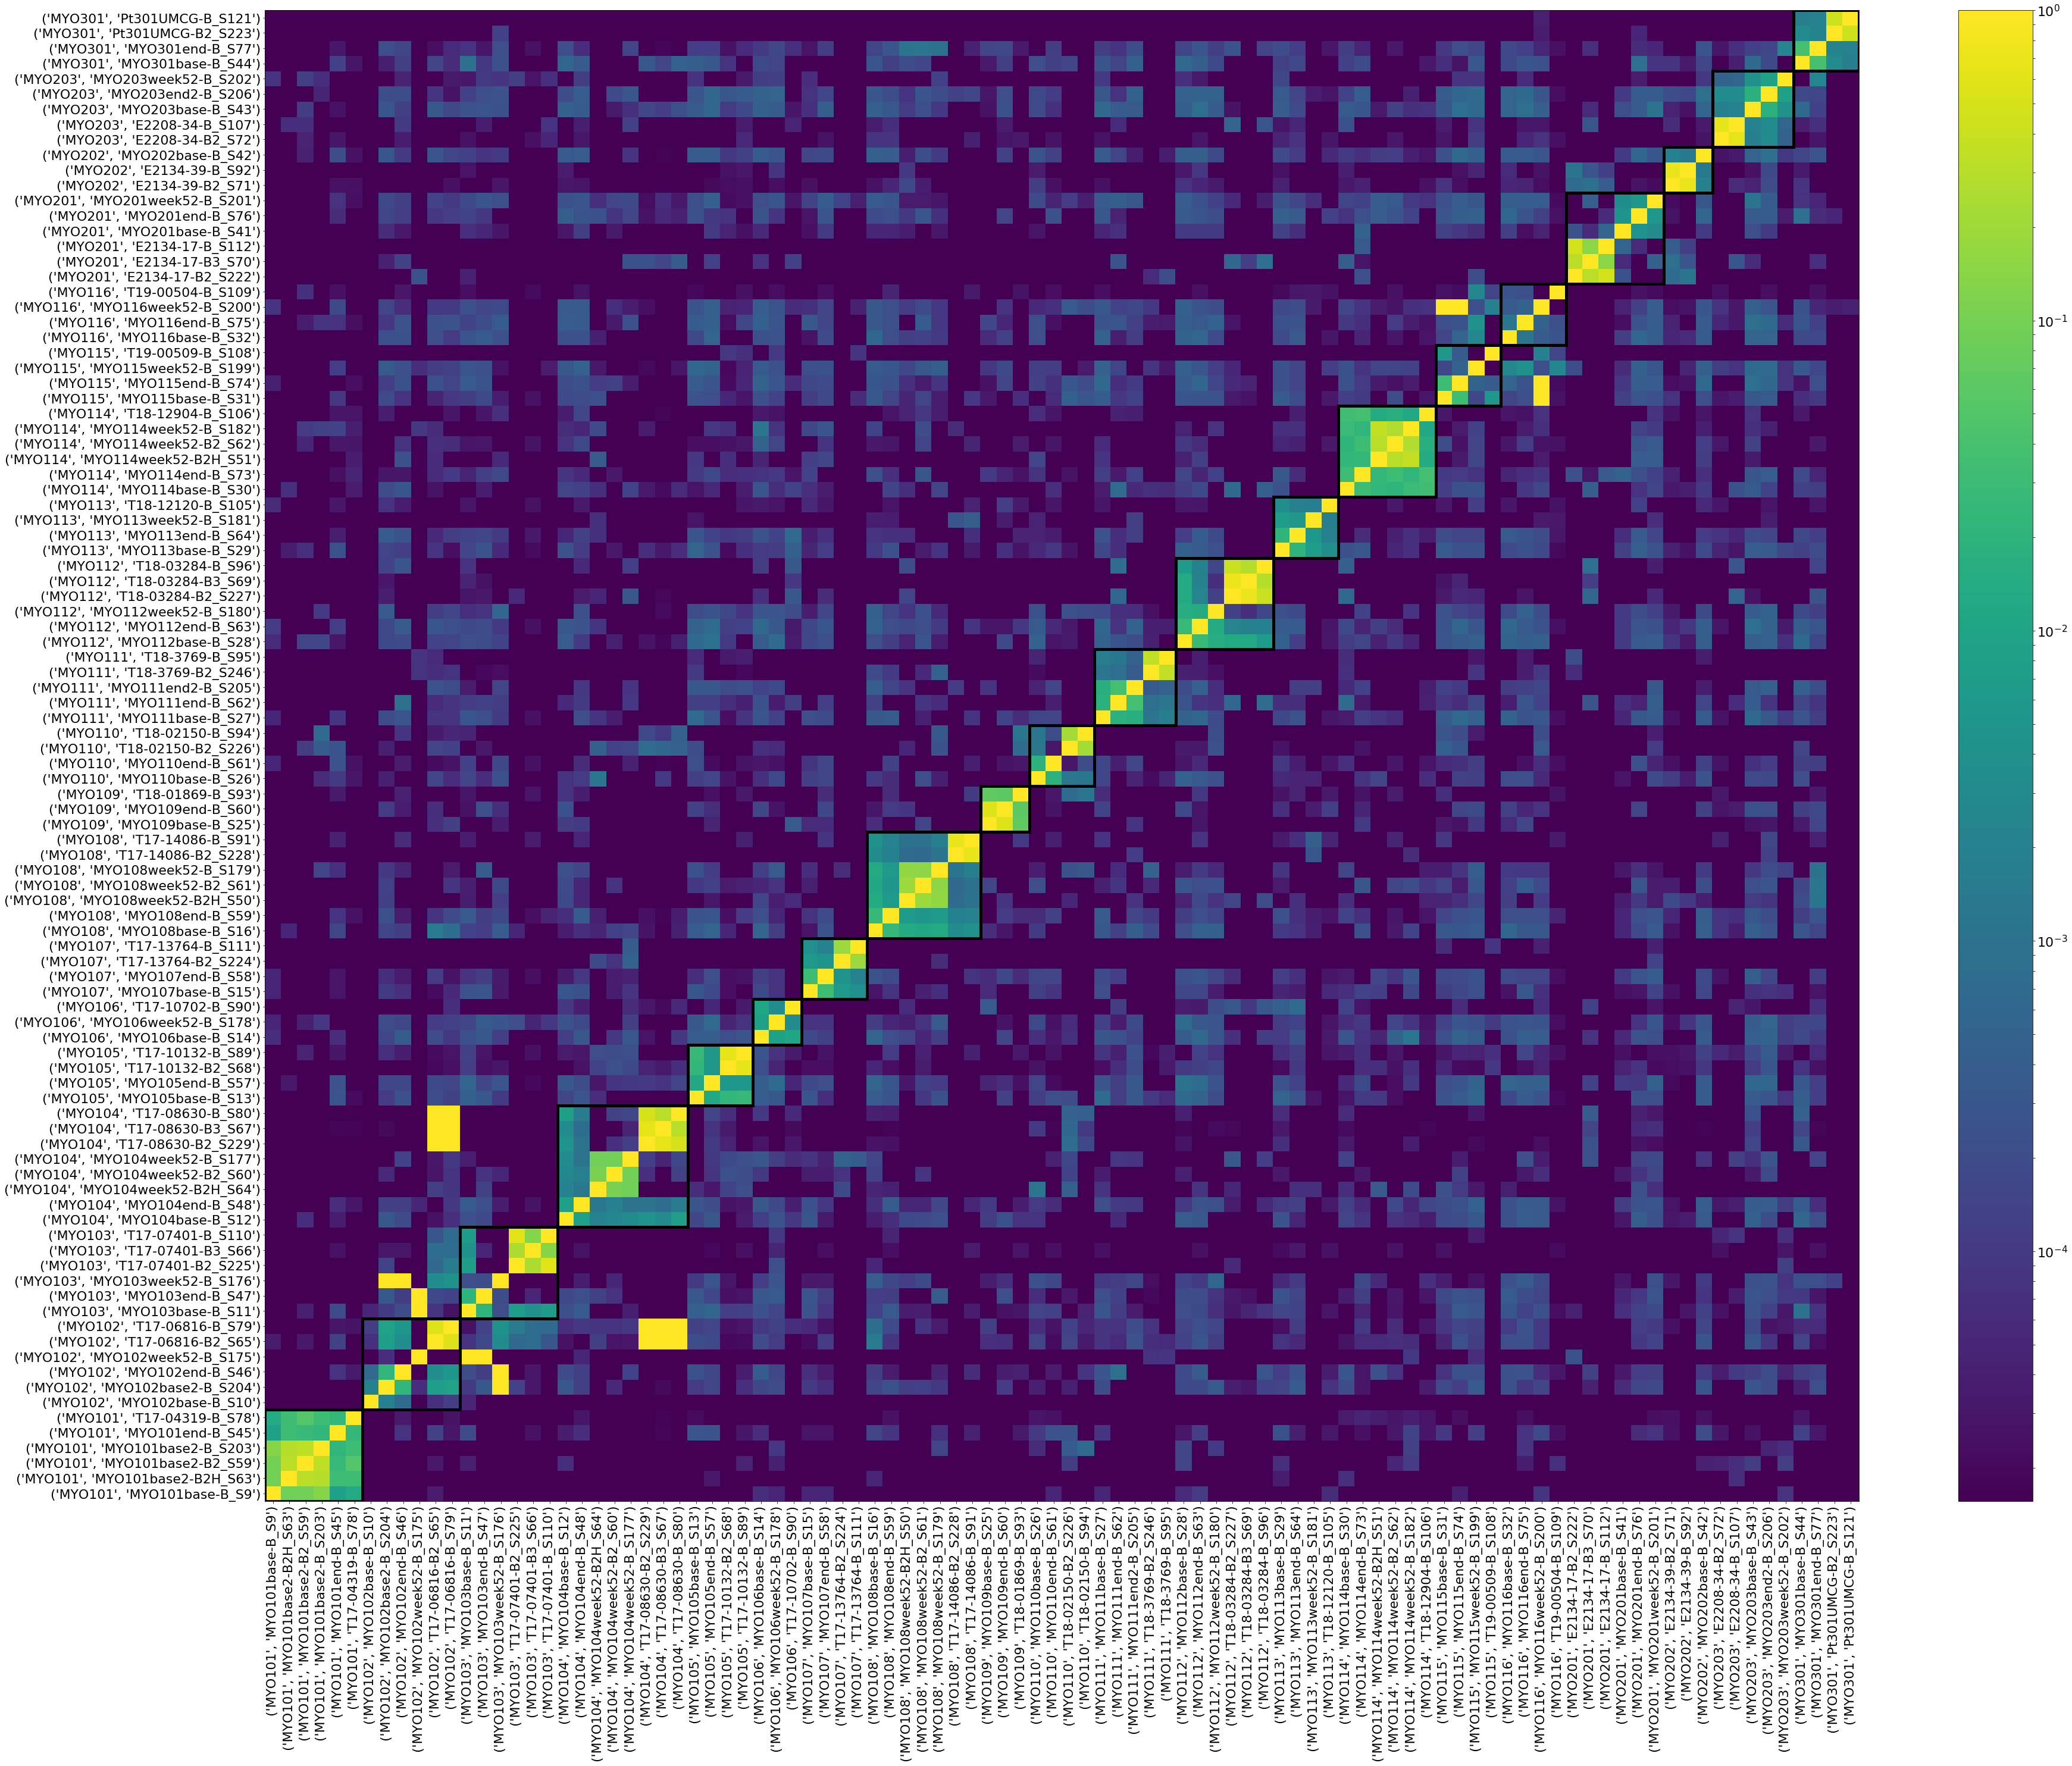

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)